### Steps to take
step 1: Import all the necessary python packages<br>
step 2: Obtain and clean data <br>
step 3: Data Exploration <br>
step 4: Modify data for Machine Learning<br>
step 5: Get dummies<br>
step 6: SMOTH<br>
step 5: Split data inot train and test<br> 
step 6: standard scaling<br>
step 7: logistic regression<br>
step 8: parameter tuning<br>
step 9: provide actionable recommendations<br>

foo <font color='red'>bar</font> foo

### Questions
1. When to apply get_dummies: before or after train-test split?
2. Do we need to worry about data leakage when doing CV? (See Medium article above)
3. Which one comes first - cost minimization or parameter tuning (C value)?
4. When to deal with imbalanced dataset? (For now we use class_weight='balanced' in sklearn LogReg)
5. Logistic_Regression solvers ‘liblinear’, ‘lbfgs’, and ‘newton-cg’ are "robust to unscaled datasets". Does this mean we don't have to scale our data??? (Note: ‘lbfgs’, and ‘newton-cg’ support no penalty (vanilla) and L2 penalty. For L1 penalty use 'saga' (which is **not** robust to unscaled datasets)

# Predicting Successful Bank Phone Campaign 

### Mod 3 Project for FIS DC DS 08262019

### Collaborators:
- **Sisay Filate**
- **Anastasia Kharina**
  

### Goals:

Predicts the outcome of a direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe to a cash investment for an agreed rate of interest over a fixed amount of time, or term. <br>
<br>
To achieve this goal, we perform logistic regression. Logistic Regression is a predictive Machine Learning classification algorithm that explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval or ratio-level independent variables.<br>


### Data Source

We used [Bank Marketing Data Set](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing) from UCI Machine Learning Repository




## Step 1: Import all the necessory python packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', size=14)
import seaborn as sns 
# sns.set(style='white')
# sns.set(style='whitegrid', color_codes=True)

#Machine Learning Modules
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix#, classifiction_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# autoreload 
%load_ext autoreload
%autoreload 2

## Step 2: Obtain and clean data

In [3]:
bank = pd.read_csv('data/bank-additional-full.csv', sep=';')

print(f"The dataset contains {bank.shape[0]} records and {bank.shape[1]} features.")
print(f"There are {bank.isna().sum().sum()} null values in the dataset")

# bank.head()
bank.columns

The dataset contains 41188 records and 21 features.
There are 0 null values in the dataset


Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

##### Cleaning data:
- Remove duplicates
- Reclassify "education" from 8 into 5 tiers
- Adding "season" feature
- Select only interesting features
- Add "data/clean_data.csv" file

In [4]:
import data_cleaning 
bank_clean = data_cleaning.cleaned_data(bank)
print(f"The dataset contains {bank_clean.shape[0]} records and {bank_clean.shape[1]} features.")
bank_clean.head()

There were 12 duplicates and they have been removed
The dataset contains 41176 records and 15 features.


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,target
0,56,housemaid,married,basic,no,no,no,telephone,may,mon,1,0,0,nonexistent,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,0,0,nonexistent,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,0,0,nonexistent,0
3,40,admin.,married,basic,no,no,no,telephone,may,mon,1,0,0,nonexistent,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,0,0,nonexistent,0


In [5]:
bank_clean.poutcome.value_counts()

nonexistent    35551
failure         4252
success         1373
Name: poutcome, dtype: int64

In [6]:
bank_clean.pdays = [0 if x==999 else 1 for x in bank_clean.pdays]
bank_clean.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,target
0,56,housemaid,married,basic,no,no,no,telephone,may,mon,1,1,0,nonexistent,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,1,0,nonexistent,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,1,0,nonexistent,0
3,40,admin.,married,basic,no,no,no,telephone,may,mon,1,1,0,nonexistent,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,1,0,nonexistent,0


### Input variables explanation (from [source](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing))
1. age (numeric)
2. job : type of job (categorical: “admin”, “blue-collar”, “entrepreneur”, “housemaid”, “management”, “retired”, “self-employed”, “services”, “student”, “technician”, “unemployed”, “unknown”)
3. marital : marital status (categorical: “divorced”, “married”, “single”, “unknown”)
4. education (categorical: “basic”, “high.school”, “illiterate”, “professional.course”, “university.degree”, “unknown”)
5. housing: has housing loan? (categorical: “no”, “yes”, “unknown”)
6. loan: has personal loan? (categorical: “no”, “yes”, “unknown”)
7. contact: contact communication type (categorical: “cellular”, “telephone”)
8. month: last contact month of year (categorical: “jan”, “feb”, “mar”, …, “nov”, “dec”)
9. day_of_week: last contact day of the week (categorical: “mon”, “tue”, “wed”, “thu”, “fri”)
10. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y=’no’). The duration is not known before a call is performed, also, after the end of the call, y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model
11. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
12. previous: number of contacts performed before this campaign and for this client (numeric)
13. poutcome: outcome of the previous marketing campaign (categorical: “failure”, “nonexistent”, “success”)

#### Predict variable (desired target):
target — has the client subscribed a term deposit? (binary: “1”, means “Yes”, “0” means “No”)


In [79]:
bank_clean.poutcome.value_counts()

nonexistent    35551
failure         4252
success         1373
Name: poutcome, dtype: int64

## Step 3: Data exploration

0    0.887337
1    0.112663
Name: target, dtype: float64


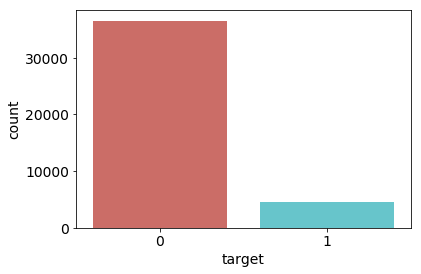

In [80]:
print(bank_clean['target'].value_counts(normalize=True))
sns.countplot(x='target', data=bank_clean, palette='hls', )
plt.show()
# plt.savefig('count_plot')

It appears that we have imbalanced classes. Percentage of non subscription is at 89% while percentage of subscription is only 11%. We will keep this in mind as we perform our analysis and make sure we address the problem. 

Text(0, 0.5, 'Frequency of Purchase')

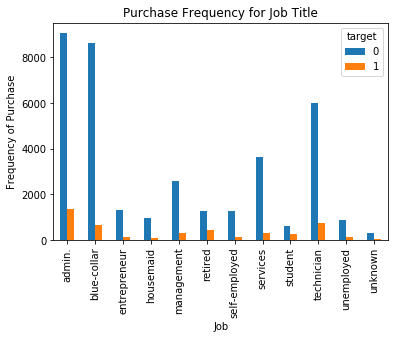

In [81]:
%matplotlib inline
pd.crosstab(bank_clean.job,bank_clean.target).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')
# plt.savefig('img/purchase_fre_job')

The frequency of purchase of the deposit depends a great deal on the job title. Thus, the job title can be a good predictor of the outcome variable.

what about marital status?

Text(0, 0.5, 'Proportion of Customers')

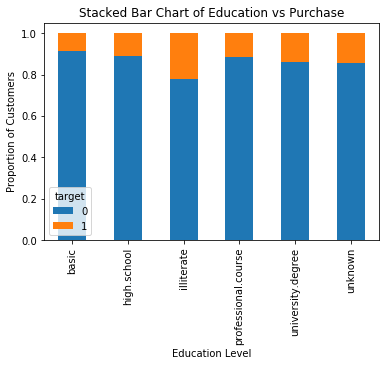

In [82]:
table=pd.crosstab(bank_clean.education,bank_clean.target)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Education vs Purchase')
plt.xlabel('Education Level')
plt.ylabel('Proportion of Customers')
# plt.savefig('mariral_vs_pur_stack')

Education seems to be a good predictor of the outcome variable.

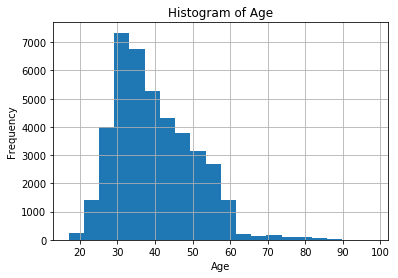

In [83]:
# age distribution
bank_clean.age.hist(bins=20)
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency');
# plt.savefig('hist_age')

Most customers in this dataset are between 30 to 40 years old.

## Step 4: Get_ dummies

In [84]:
bank_clean.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,target
0,56,housemaid,married,basic,no,no,no,telephone,may,mon,261,1,0,0,nonexistent,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,0,0,nonexistent,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,0,0,nonexistent,0
3,40,admin.,married,basic,no,no,no,telephone,may,mon,151,1,0,0,nonexistent,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,0,0,nonexistent,0


In [85]:
# bank_clean.select_dtypes(include='object').head()

In [86]:
X = bank_clean.drop('target', axis = 1)
y = bank_clean['target']
X_dum = pd.get_dummies(X, 
               columns = ['job', 'marital', 'education', 'housing', 'default', 'loan', 'contact', 'month', 'day_of_week','poutcome'], 
               drop_first= True)
print(X_dum.shape)
print(X_dum.columns)
X_dum.head()

(41176, 46)
Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_married', 'marital_single',
       'marital_unknown', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'housing_unknown', 'housing_yes',
       'default_unknown', 'default_yes', 'loan_unknown', 'loan_yes',
       'contact_telephone', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')


,age,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,56,261,1,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,1,0
1,57,149,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
2,37,226,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
3,40,151,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
4,56,307,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0


## Step 5: Train-test split

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X_dum, y, random_state = 0, stratify = y, test_size = .2)
print('Train and test datas are split at 80% to 20% ')

Train and test datas are split at 80% to 20% 


In [22]:
print(X_train.shape)
print(y_train.shape)

(32940, 46)
(32940,)


## Step 6: Standard Scaling

In [90]:
# StandardScaler
scaler = StandardScaler().fit(X_train)
columns = X_train.columns

scaled_train = scaler.transform(X_train)
X_train_scaled = pd.DataFrame(scaled_train, columns=columns)
# ## then used 
# # scaler.transform(X_test)
print(X_train_scaled.shape)
X_train_scaled.head()

(32940, 46)


,age,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,-0.293135,-0.335549,-0.564625,-0.19645,1.679762,-0.539824,-0.191649,-0.165773,-0.273916,-0.209108,...,-0.709185,-0.333783,-0.129585,-0.119922,-0.511124,-0.515608,-0.494967,-0.494729,-2.511053,-0.186655
1,-0.676809,-0.569503,-0.204519,-0.19645,-0.350523,-0.539824,-0.191649,-0.165773,-0.273916,-0.209108,...,-0.709185,-0.333783,-0.129585,-0.119922,-0.511124,-0.515608,2.020338,-0.494729,0.398239,-0.186655
2,-0.676809,-0.972212,-0.564625,-0.19645,-0.350523,-0.539824,-0.191649,-0.165773,-0.273916,-0.209108,...,-0.709185,-0.333783,-0.129585,-0.119922,-0.511124,-0.515608,2.020338,-0.494729,0.398239,-0.186655
3,-0.197216,-0.607857,0.155587,-0.19645,-0.350523,-0.539824,-0.191649,-0.165773,-0.273916,-0.209108,...,-0.709185,-0.333783,-0.129585,-0.119922,1.956473,-0.515608,-0.494967,-0.494729,0.398239,-0.186655
4,0.090540,1.006812,-0.564625,-0.19645,-0.350523,-0.539824,-0.191649,-0.165773,-0.273916,-0.209108,...,-0.709185,-0.333783,-0.129585,-0.119922,1.956473,-0.515608,-0.494967,-0.494729,0.398239,-0.186655


In [27]:
# logreg_sample = LogisticRegression(C=1e9, solver='newton-cg')
# logreg_sample.fit(X_train_scaled, y_train)
# y_hat_new = logreg_sample.predict(X=X_train_scaled)
# y_hat_new.shape

(32940,)

## Step 7.1: Dealing with imbalanced classes -- using SMOTE 
we need to up-sample the no-subscription using the SMOTE algorithm(Synthetic Minority Oversampling Techique).
Works by creating synthetic samples from the minor class (no-subscription) instead of creating copies.
Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.
We are going to implement SMOTE in Python.

In [91]:
# dealing with over-sampling using SMOTE 
from imblearn.over_sampling import SMOTE 

# columns = scaled_train.columns

os = SMOTE(random_state=0)
os_data_X, os_data_y = os.fit_sample(X_train_scaled, y_train)
# os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
os_data_y = pd.Series(os_data_y)

# check numbers
print('Length of oversampled data is', len(os_data_X))
print('Number of no subscription in oversampled data', np.sum(os_data_y==0))
print('Number of subscription', np.sum(os_data_y==1))
print('Proportion of no subscription data in oversampled data is', np.sum(os_data_y==0)/len(os_data_y))
print('Proportion of subscription data in oversampled data is', np.sum(os_data_y==1)/len(os_data_y))

Length of oversampled data is 58458
Number of no subscription in oversampled data 29229
Number of subscription 29229
Proportion of no subscription data in oversampled data is 0.5
Proportion of subscription data in oversampled data is 0.5


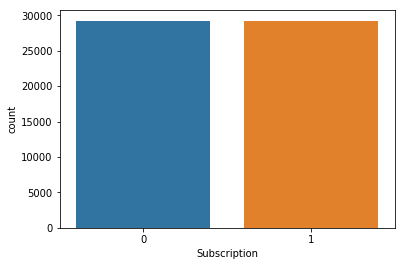

In [92]:
# print(bank_clean['target'].value_counts(normalize=True))
sns.countplot(x=os_data_y)#, data=bank_clean, palette='hls', )
plt.xlabel('Subscription')
plt.show()

In [93]:
# after using Synthetic Minority Oversampling Techique
print(os_data_X.shape)
print(len(os_data_y))
# os_data_y.value_counts(normalize=True)

(58458, 46)
58458


## logit 

In [94]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

def print_metrics(y_train, y_hat):
    print(f"precision = {round(precision_score(y_train, y_hat),2)}")
#     print(f"score = {round(lr.score(y_train, y_hat),2)}")
    print(f"recall = {round(recall_score(y_train, y_hat),2)}")
    print(f"accuracy = {round(precision_score(y_train, y_hat),2)}")
    print(f"f1 score = {round(f1_score(y_train, y_hat),2)}")

In [95]:
## Let's go with the vanilla case - no regularization
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(os_data_X, os_data_y)
os_data_y_hat = logreg.predict(os_data_X)
# os_data_y_hat
print_metrics(os_data_y, os_data_y_hat)

precision = 0.86
recall = 0.86
accuracy = 0.86
f1 score = 0.86


In [104]:
X_col = X_train.columns
X_df = pd.DataFrame(data=os_data_X, columns=X_col)
y_df = pd.DataFrame(data=os_data_y, columns=['Sub'])
# os_data_X_df.head()
print(type(os_data_X_df))
print(type(os_data_y_df))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [108]:
import statsmodels.api as sm
logit_model=sm.Logit(X_df[X_col], y_df['Sub']).fit()
# result = logit_model.fit()
print(logit_model.summary2())
# result.summary()

# Create, fit model
#     mod = sm.Logit(endog=y_train, exog=X_train)
#     res = mod.fit(method='bfgs', maxiter=100)

ValueError: endog must be in the unit interval.

### Recursive feature elimination

In [114]:
os_data_y.values.ravel()

array([0, 0, 0, ..., 1, 1, 1])

In [130]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='lbfgs')

rfe = RFE(logreg, 10)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)
# rfe.get_support

[False  True  True  True False  True False False False False False False
 False False False False False False False False False False False False
 False False  True False False False  True  True False  True False False
  True  True False False False False False False False False]
[16  1  1  1  9  1 18 33 17  3 19  2 11  6 32 23 15  8 34 28 31 36 14 20
 35 24  1 21 37 13  1  1 22  1 26  5  1  1  4 12 27 25 29 30 10  7]


In [125]:
X_train.columns 


Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_married', 'marital_single',
       'marital_unknown', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'housing_unknown', 'housing_yes',
       'default_unknown', 'default_yes', 'loan_unknown', 'loan_yes',
       'contact_telephone', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')

In [126]:
X_train.head()

,age,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
29109,37,171,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14436,33,110,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
40268,33,5,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
10249,38,100,3,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
15770,41,521,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [137]:
rfe_cols = ['duration', 'campaign', 'pdays', 'job_blue-collar', 'default_unknown', 'contact_telephone', 
            'month_aug', 'month_jul', 'month_may', 'month_nov']

In [141]:
X_new = X_train[rfe_cols]
print(X_new.shape)
X_new.head()


(32940, 10)


,duration,campaign,pdays,job_blue-collar,default_unknown,contact_telephone,month_aug,month_jul,month_may,month_nov
29109,171,1,0,0,0,0,0,0,0,0
14436,110,2,0,0,0,0,0,1,0,0
40268,5,1,0,0,0,1,0,1,0,0
10249,100,3,0,0,0,1,0,0,0,0
15770,521,1,0,0,0,0,0,1,0,0


#### SM model

In [146]:
import statsmodels.api as sm
logit_model = sm.Logit(y, X_new)
result = logit_model.fit()
print(result.summary())

ValueError: The indices for endog and exog are not aligned

### Cross validation

In [109]:
## To get our baseline, we'll do a 'vanilla' case - no regularization.
## In this case, we do not scale our data
logreg_vanilla = LogisticRegression(C=1e9, solver='newton-cg')
logreg_vanilla.fit(os_data_X, os_data_y)
y_hat_vanilla = logreg_vanilla.predict(X=os_data_X)


In [111]:
print_metrics(os_data_y, y_hat_vanilla)

precision = 0.86
recall = 0.86
accuracy = 0.86
f1 score = 0.86


#### For vanilla

In [ ]:
# import logistic_regression as lr
# vanilla_result = lr.cross_validation(n=10, shuffle=True, lr='vanilla', X_train=os_data_X, y_train=os_data_y)
# vanilla_result

#### For l2

In [ ]:
# l2_result = lr.cross_validation(n=10, shuffle=True, lr='l2', X_train=os_data_X, y_train=os_data_y)
# l2_result

In [ ]:
l2_reg = LogisticRegression(C=1, solver='newton-cg', class_weight='balanced', max_iter=1000)
l2_reg.fit(os_data_X, os_data_y)
l2_reg_prd = l2_reg.predict(os_data_X)
print_metrics(os_data_y, l2_reg_prd,lr_reg=l2_reg)

#### For l1

In [ ]:
l1_reg = LogisticRegression(C=1, solver='saga',penalty='l1', max_iter=1000)
l1_reg.fit(os_data_X, os_data_y)
l1_reg_prd = l1_reg.predict(os_data_X)
print_metrics(os_data_y, l1_reg_prd, lr_reg=l1_reg)

In [ ]:
l1_result = lr.cross_validation(n=10, shuffle=True, lr='l1', X_train=os_data_X, y_train=os_data_y)
l1_result

In [ ]:
# calculate the mean
print('vanilla regularization', vanilla_result.mean(axis=0))
print('l1 regularization', l1_result.mean(axis=0))
print('l2 regularixation', l2_result.mean(axis=0))

In [ ]:
# calculate the std
print('vanilla regularization', vanilla_result.std(axis=0))
print('l1 regularization', l1_result.std(axis=0))
print('l2 regularixation', l2_result.std(axis=0))

In [ ]:
y_hat_df = pd.DataFrame(data=y_hat, columns=['y_hat'])
y_hat_df.y_hat.value_counts(normalize=True)

In [ ]:
true_posetive = np.count_nonzero(y_hat)
accuracy = true_posetive/len(y_hat)
print('accuracy', accuracy)
print('values', len(y_hat))


## Step 7.2: Using class_weight parameter

In [ ]:
X = bank_clean.drop('target', axis = 1)
y = bank_clean['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, stratify = y, test_size = .2)
print('Train and test datas are split at 80% to 20% ')

In [ ]:
# check the shape of our training data 
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

In [ ]:
y_train.mean()

## Step 4: Modify data for Machine Learning

In [ ]:
X_train.head()

In [ ]:
bank_clean.columns

In [ ]:
dummed_train = pd.get_dummies(X_train, 
               columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'season', 'day_of_week', 'poutcome'], 
               drop_first= True)

In [ ]:
dummed_train.head()
print(dummed_train.shape)
print(dummed_train.columns)

In [ ]:
# calculate for age
mu, std = dummed_train.age.mean(), dummed_train.age.std()
print('mean age', mu, 'age std', std)
print('Standardized value for the first row is:', (dummed_train.age[1233]-mu)/std)
print(dummed_train.age[1233])
dummed_train.head()

## Step 7: Logistic Regression

In [ ]:
## To get our baseline, we'll do a 'vanilla' case - no regularization.
## In this case, we do not scale our data
logreg = LogisticRegression(class_weight='balanced', solver='newton-cg')
logreg.fit(dummed_train, y_train)

In [ ]:
print(logreg.score(dummed_train, y_train))

In [ ]:

#Standard Scaler to be used within pipelines.  
class StScaler(StandardScaler):
    def fit_transform(slf,X,y=None):
        print(f"transformed rows: {len(X)}")
        return super().fit_transform(X,y)

#Using pipeline to avoid data leakage within CV process 
pipe = Pipeline([
    ('scaler', StScaler()),
    ('logreg', LogisticRegression(C = 1e9, 
                                 solver = 'newton-cg',
                                 max_iter = 1000,
                                 class_weight = 'balanced'))
])

print(f"train data length: {len(dummed_train)} rows")
print(cross_val_score(pipe,dummed_train,y_train, cv=5))

## Step 8: Parameter Tuning

In [ ]:
#GridSearchCV for parameter tuning

# param_grid = {''}

# search = GridSearchCV(estimator=pipe,
#                       cv=5,
#                       param_grid=
#                       return_train_score=True)

# search.fit(X_train, y_train)
